In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az


sns.set_style("whitegrid")

## Множественная логистическая регрессия


По аналогии с множественной линейной регрессией множественная логистическая регрессия предполагает использование более одной независимой переменной. Попробуем объединить данные о длине и ширине чашелистиков.

In [5]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
y_1 = pd.Categorical(df['species']).codes
columns = ['sepal_length', 'sepal_width'] #['petal_length', 'petal_width'] 
x_o = df[columns].values
x_means = x_o.mean(axis=0)
x_1 = (x_o - x_means)

### Граница решения (по аналогии, можно пропустить)

По определению модели верно следующее равенство:
$$\theta = logistic(\alpha+x_1\beta_1+x_2\beta_2)$$

Из определения логистической функции известно, что $\theta = 0.5$, когда аргумент логистической регрессии равен нулю:
$$0.5 = logistic(\alpha+x_1\beta_1+x_2\beta_2) \Leftrightarrow 0 =\alpha+x_1\beta_1+x_2\beta_2$$

После преобразования равенства находим значение $x_2$, для которого $\theta =
0.5$, то есть следующее выражение:
$$x_2 = -\dfrac{\alpha}{\beta_2}-\dfrac{\beta_1}{\beta_2}x_1$$

Это выражение для границы решения имеет математическую форму, равнозначную уравнению прямой линии, где первый член (свободный член) представляет отрезок отсечения, а второй член – коэффициент угла наклона. 
Граница - прямая линиия. 
Если исследуется один признак, то данные одномерны, и их можно разделить на две группы с помощью точки. 
Если рассматриваются два признака, то формируется двумерное пространство данных, которое можно разделить линией. 
Для трех измерений границей будет плоскость, для измерений более высоких порядков - гиперплоскости. 

### Реализация модели

In [6]:
with pm.Model() as model_1: 
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10) 
    β = pm.Normal('β', mu=0, sigma=2, shape=len(columns)) 
     
    μ = α_tmp + pm.math.dot(x_1, β) 
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) 
    α = pm.Deterministic('α', α_tmp - pm.math.dot(β,x_means))
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * (x_1[:,0]+x_means[0]))
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_1) 
 
    trace_1 = pm.sample(1000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_tmp, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [7]:
varnames = ['α','β','bd']
az.summary(trace_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_tmp,0.409,0.509,-0.488,1.389,0.009,0.007,3577.0,2746.0,1.0
β[0],5.107,1.043,3.265,7.145,0.019,0.014,2983.0,2923.0,1.0
β[1],-5.056,1.022,-6.889,-3.107,0.016,0.012,3994.0,2631.0,1.0
θ[0],0.036,0.024,0.002,0.080,0.000,0.000,4631.0,2925.0,1.0
θ[1],0.133,0.068,0.027,0.262,0.001,0.001,5285.0,3366.0,1.0
...,...,...,...,...,...,...,...,...,...
bd[95],3.423,0.143,3.177,3.699,0.002,0.002,4050.0,2996.0,1.0
bd[96],3.423,0.143,3.177,3.699,0.002,0.002,4050.0,2996.0,1.0
bd[97],3.945,0.262,3.453,4.416,0.004,0.003,4458.0,2908.0,1.0
bd[98],2.797,0.113,2.584,3.004,0.002,0.001,5253.0,2744.0,1.0


In [8]:
az.summary(trace_1, var_names=['α','β'] )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-11.860,5.701,-22.690,-1.641,0.087,0.066,4351.0,3271.0,1.0
β[0],5.107,1.043,3.265,7.145,0.019,0.014,2983.0,2923.0,1.0
β[1],-5.056,1.022,-6.889,-3.107,0.016,0.012,3994.0,2631.0,1.0


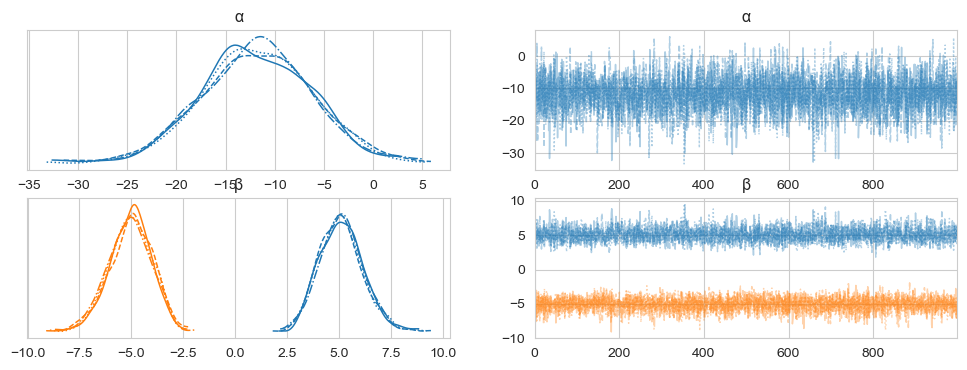

In [9]:
# Внимание!!! Компактная отрисовка. Все переменные с одним имененм на одном графике!!!
az.plot_trace(trace_1, var_names = ['α','β'],compact=True);

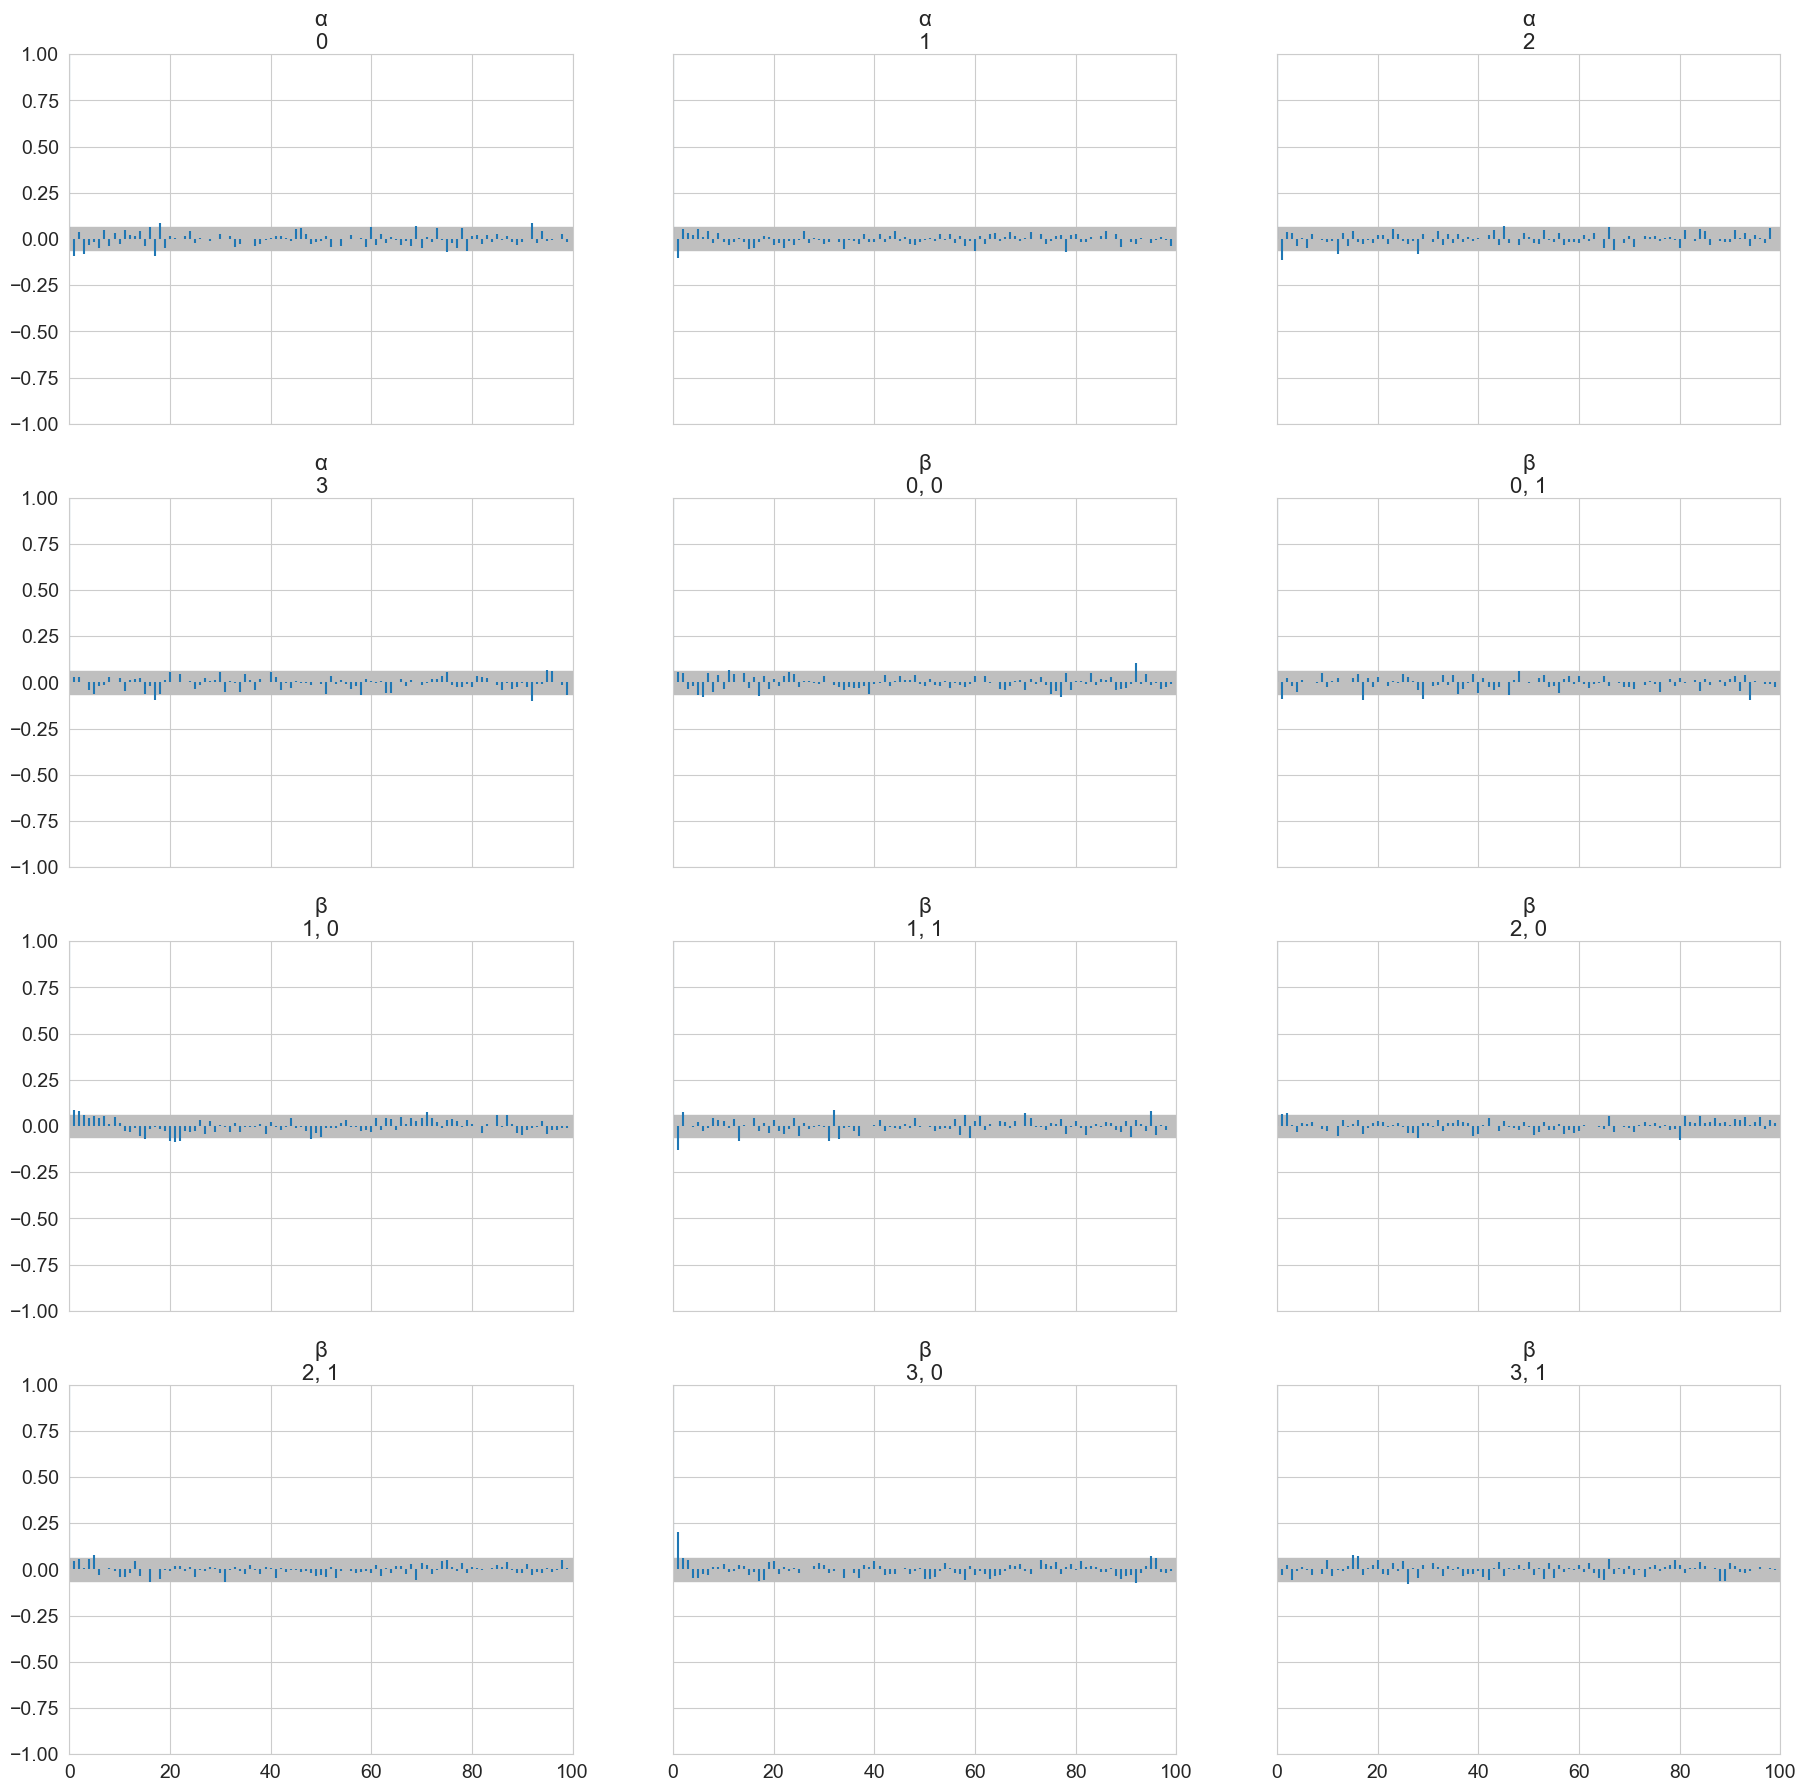

In [10]:
az.plot_autocorr(trace_1, ['α', 'β']);

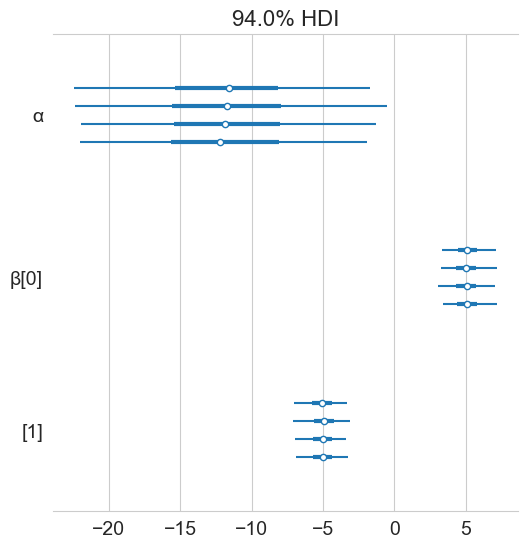

In [13]:
varnames = ['α', 'β'] 
az.plot_forest(trace_1, var_names=varnames);

По аналогии с ранее используемой одной прогнозирующей переменной сформируем диаграмму данных и график границы решения:

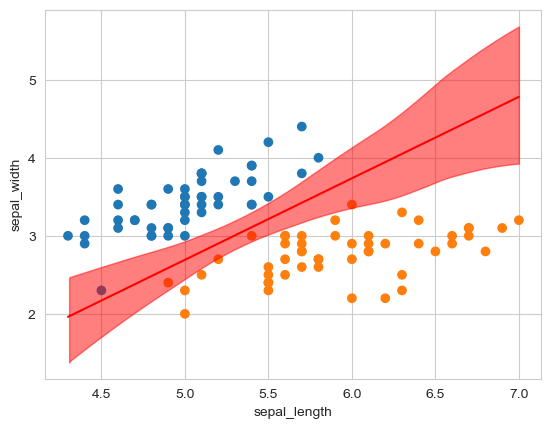

In [14]:
idx = np.argsort(x_1[:,0]) 
bd = trace_1.posterior['bd'].mean(("chain", "draw"))[idx]

plt.scatter(x_o[:,0], x_o[:,1], c=[f'C{i}' for i in y_1]) 

plt.plot(x_o[:,0][idx], bd, color='r'); 
az.plot_hdi(x_o[:,0], trace_1.posterior['bd'], color='r')
 
plt.xlabel(columns[0]);
plt.ylabel(columns[1]);

Граница решения представлена прямой линией, как уже наблюдалось в предыдущем примере. Пусть вас не смущают криволинейные границы полосы интервала ПАР 94 %. Явная кривизна является результатом наличия нескольких линий, вращающихся относительно центральной области (приближенно: относительно среднего значения $x$ и среднего значения $y$).

### Интерпретация коэффициентов логистической регрессии

При интерпретации коэффициентов $\beta$ логистической регрессии необходимо быть внимательным и осторожным. 
В этом случае интерпретация не так проста и очевидна, как для линейных моделей, Использование логистической функции обратной связи приводит к нелинейности, которую необходимо учитывать. 

Если коэффициент β положительный, то при увеличении $x$ увеличивается вероятность $p(y = 1)$ на некоторую величину, но эта величина не является линейной функцией от $x$ Этот факт можно отчетливо наблюдать схеме с логистической кривой -  вместо линии с постоянным углом наклона здесь изображена S-образная линия, угол наклона которой изменяется как функция от $x$. Давайте поясним, как изменяется вероятность $p(y = 1)$ при изменении $\beta$.

Формула основной логистической модели:
$$\theta = logistic(\alpha+X\beta)$$

Обратной к логистической функции является логит-функция (logit):
$$logit(z) = \ln\left( \dfrac{z}{1-z}\right)$$

Таким образом, если взять первую формулу в этом разделе и применить логит-функцию к обоим ее членам, то получится следующая формула:
$$logit(\theta) = \alpha+X\beta$$

Или
$$\ln\left( \dfrac{\theta}{1-\theta}\right)=\alpha+X\beta$$

Тогда:
$$\ln\left( \dfrac{p(y = 1)}{1-p(y = 1)}\right)=\alpha+X\beta$$

Значение под логарифмом $\cfrac{p(y = 1))}{1 – p(y = 1)}$ можно обозначить как "шансы на успех"

Шансы на успех определяются как отношение вероятности успешного результата к вероятности неудачного результата. Вероятность выпадения 2 при броске симметричной игральной кости равна 1/6, таким образом, шансы наступления этого события определяются как (1/6)/(5/6) ≃ 0.2 или как одно благоприятное событие к пяти неблагоприятным событиям. Понятие шансов часто используют участники азартных игр, в основном потому, что шансы представляют собой более интуитивно понятный инструмент, чем чистые вероятности, когда речь идет о правильной методике ставок.

В логистической регрессии коэффициент $\beta$ соответствует  увеличению в единицах логарифма шансов по отношению к единице увеличения переменной $x$.

Преобразование вероятности в шансы является монотонным, то есть шансы возрастают при увеличении вероятности и уменьшаются, если вероятность снижается. Вероятность ограничена интервалом $[0, 1]$, в то время как шансы существуют в интервале $[0, \infty)$. 
Логарифмирование – это тоже монотонное преобразование, поэтому значения логарифмов шансов располагаются в интервале $(–\infty, +\infty)$. 

На схеме показана взаимосвязь вероятностей с шансами и логарифмами шансов:

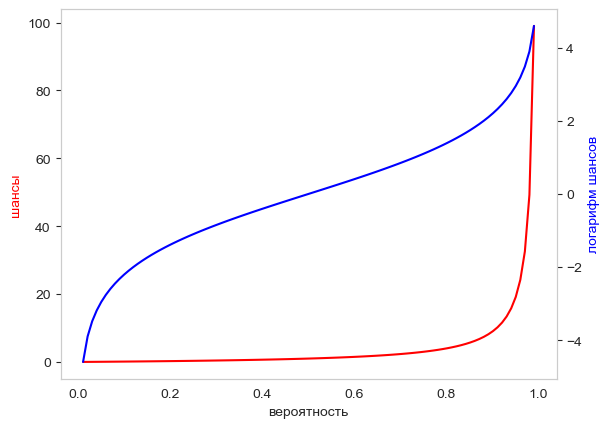

In [21]:
probability = np.linspace(0.01, 0.99, 100)
odds = probability / (1 - probability)

_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(probability, odds, 'r')
ax2.plot(probability, np.log(odds), 'b')

ax1.set_xlabel('вероятность')
ax1.set_ylabel('шансы', color='r')
ax2.set_ylabel('логарифм шансов', color='b')
ax1.grid(False)
ax2.grid(False)

Таким образом, значения коэффициентов, получаемых с помощью функции <code>summary</code>, указываются в масштабе логарифмов шансов.

In [23]:
df = az.summary(trace_1, var_names=['α','β'] )
df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-11.860,5.701,-22.690,-1.641,0.087,0.066,4351.0,3271.0,1.0
β[0],5.107,1.043,3.265,7.145,0.019,0.014,2983.0,2923.0,1.0
β[1],-5.056,1.022,-6.889,-3.107,0.016,0.012,3994.0,2631.0,1.0


В приведенном ниже  кода вычисляются логарифмы шансов для ириса разноцветного (versicolor) как 
$$\text{log_odds_versicolor_i} = \alpha + \beta_1x_1 + \beta_2x_2,$$ 
затем вероятность принадлежности к классу versicolor с помощью логистической функции. После этого вычисления повторяются при том же значении $x_2$, но с увеличением значения $x_1$ на 1:

In [24]:
from scipy.stats import logistic

x_1 = 4.5  # sepal_length
x_2 = 3   # sepal_width 

log_odds_versicolor_i = (df['mean'] * [1, x_1, x_2]).sum()
probability_versicolor_i = logistic.cdf(log_odds_versicolor_i)

log_odds_versicolor_g = (df['mean'] * [1, x_1 + 0.8, x_2]).sum()
probability_versicolor_g = logistic.cdf(log_odds_versicolor_g)

log_odds_versicolor_f = (df['mean'] * [1, x_1 + 3, x_2]).sum()
probability_versicolor_f = logistic.cdf(log_odds_versicolor_f)

print([log_odds_versicolor_i , probability_versicolor_i]) 
print([log_odds_versicolor_g , probability_versicolor_g])
print([log_odds_versicolor_f , probability_versicolor_f])

[-4.046499999999998, 0.01718304078479688]
[0.039100000000001245, 0.5097737548472143]
[11.274500000000003, 0.9999873076701072]


### Что происходит если переменные коррелируют?

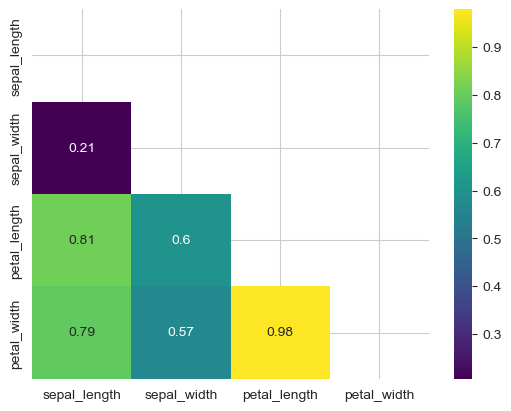

In [41]:
corr =iris[iris['species'] != 'virginica'].drop(['species'], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis');

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_tmp, β]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 16 seconds.


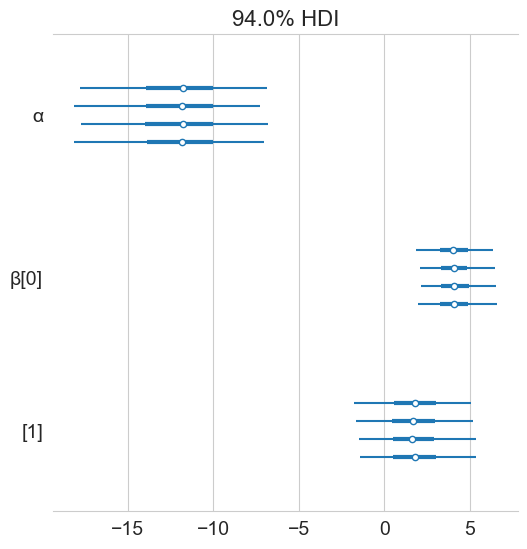

In [47]:
iris = sns.load_dataset("iris")
df = iris[iris['species'].isin(['setosa', 'versicolor'])]

y_1 = pd.Categorical(df['species']).codes
columns = ['petal_length', 'petal_width'] 
x_o = df[columns].values
x_means = x_o.mean(axis=0)
x_1 = (x_o - x_means)

with pm.Model() as model_2: 
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10) 
    β = pm.Normal('β', mu=0, sigma=2, shape=len(columns)) 
     
    μ = α_tmp + pm.math.dot(x_1, β) 
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) 
    α = pm.Deterministic('α', α_tmp - pm.math.dot(β,x_means))
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * (x_1[:,0]+x_means[0]))
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_1) 
 
    trace_2 = pm.sample(3000, chains = 4, cores = 4)

varnames = ['α', 'β'] 
az.plot_forest(trace_2, var_names=varnames);

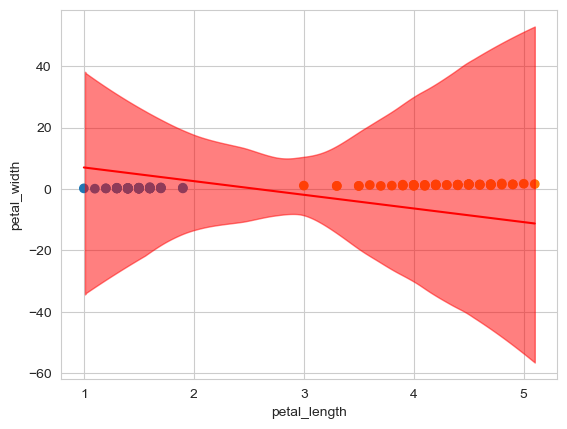

In [49]:
idx = np.argsort(x_1[:,0]) 
bd = trace_2.posterior['bd'].mean(("chain", "draw"))[idx]

plt.scatter(x_o[:,0], x_o[:,1], c=[f'C{i}' for i in y_1]) 

plt.plot(x_o[:,0][idx], bd, color='r'); 
az.plot_hdi(x_o[:,0], trace_2.posterior['bd'], color='r')
 
plt.xlabel(columns[0]);
plt.ylabel(columns[1]);

Давайте попробуем исправить ситуацию.

In [52]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
y_1 = pd.Categorical(df['species']).codes
columns = ['petal_length', 'petal_width'] 

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

X = df[columns]
X_transform = StandardScaler().fit_transform(X)

with pm.Model() as model_3: 
    α = pm.Normal('α', mu=0, sigma=10) 
    #β = pm.Normal('β', mu=0, sd=2, shape=len(columns))  
    β = pm.StudentT('β', mu=0, sigma=2, nu=50, shape=len(columns)) # nu =50-70
    μ = α + pm.math.dot( X_transform,β) 
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) 
    
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * X_transform[:,0])
    
    yl = pm.Bernoulli('yl', p=θ, observed=y_1) 
 
    trace_3 = pm.sample(3000, chains = 4, cores = 4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 17 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


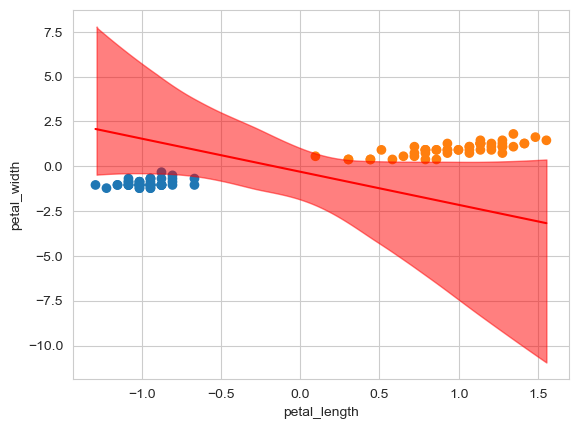

In [56]:
idx = np.argsort(X_transform[:,0]) 
bd = trace_3.posterior['bd'].mean(("chain", "draw"))[idx]

plt.scatter(X_transform[:,0], X_transform[:,1], c=[f'C{i}' for i in y_1]) 

plt.plot(X_transform[:,0][idx], bd, color='r'); 
az.plot_hdi(X_transform[:,0], trace_3.posterior['bd'], color='r')
 
plt.xlabel(columns[0]);
plt.ylabel(columns[1]);

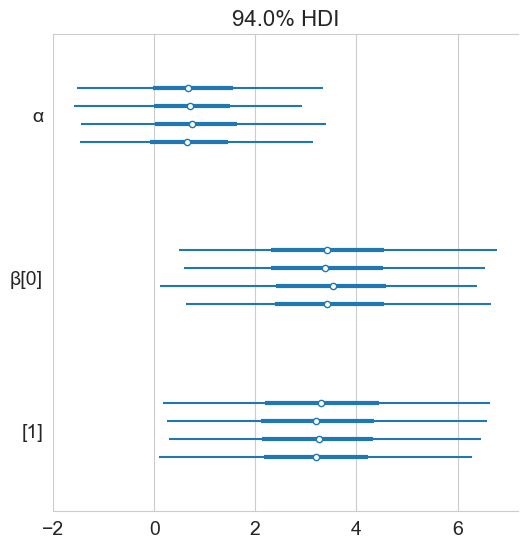

In [57]:
varnames = ['α', 'β'] 
az.plot_forest(trace_3, var_names=varnames);

### Робастная логистическая регрессия

На предидущем занятии мы  рассматривалась методика корректировку выбросов без прямого моделирования фактора, порождающего эту проблему. 

Похожая методика, может
применяться для выполнения более надежной (робастной) версии логистической регрессии. Напомним, что при использовании логистической регрессии мы моделируем данные как биномиальные, то есть нули и единицы. Поэтому может возникнуть ситуация, когда в наборе данных обнаружатся ненужные нули и/или единицы (из-за погрешностей наблюдений, выброcов). 

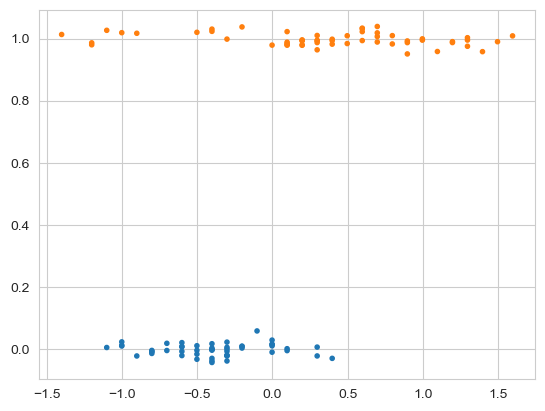

In [148]:
iris = sns.load_dataset("iris")
df = iris[iris['species'].isin(['setosa', 'versicolor'])]
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length'
x_0 = df[x_n].values

y_0 = np.concatenate((y_0, np.ones(6, dtype=int)))
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4])) 

x_c = x_0 - x_0.mean()

plt.scatter(x_c, np.random.normal(y_0, 0.02),
            marker='.', color=[f'C{x}' for x in y_0])

#plt.plot(x_c, y_0, 'o', color='k');

Здесь мы получили несколько ирисов многоцветных (значения 1) с преднамеренно укороченной (то есть неправильной) длиной чашелистика. Эту сиуацию можно исправить с помощью смешанной модели. 

Можно сказать, что значение выходной переменной получается с вероятностью $\pi$ при случайном угадывании (предсказании) или с вероятностью $1 – \pi$ из модели логистической регрессии. запишем, что:
$$p = \pi 0.5 + (1 – \pi)logistic(\alpha + X\beta)$$

Заметим, что при $\pi = 1$ получаем $p = 0.5$, а при $\pi = 0$ возвращаемся к формуле логистической регрессии. 

In [143]:
with pm.Model() as model_rlg:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10) 
    β =     pm.Normal('β',     mu=0, sigma=10) 
    μ = α_tmp + x_c*β
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) 
    
    π = pm.Beta('π', 1., 1.)
    p = π * 0.5 + (1 - π) * θ
    
    yl = pm.Bernoulli('yl', p=p, observed=y_0) # ВНИМАНИЕ p=p, а не правдоподобию !
    
    # обратное перемасштабирование
    α = pm.Deterministic('α', α_tmp - β * x_0.mean())
    bd = pm.Deterministic('bd', -α/β)

    trace_rlg = pm.sample(1000, chains = 4, cores = 4, target_accept=0.95)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_tmp, β, π]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


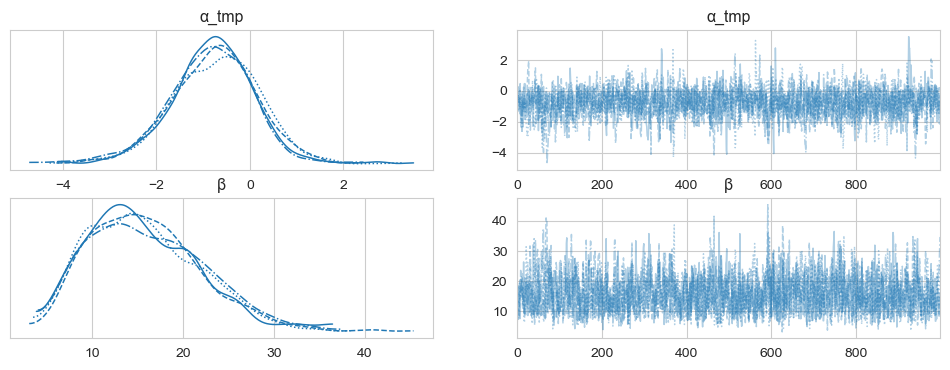

In [144]:
varnames = ['α_tmp','β']
az.plot_trace(trace_rlg, varnames);

In [181]:
az.summary(trace_rlg, var_names=['α','β','π', 'bd'] )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-86.557,33.922,-146.161,-29.674,0.821,0.590,1796.0,2251.0,1.0
β,15.876,6.208,5.473,26.803,0.149,0.107,1820.0,2349.0,1.0
π,0.302,0.079,0.157,0.447,0.002,0.001,2020.0,1742.0,1.0
bd,5.450,0.058,5.337,5.560,0.001,0.001,2574.0,2381.0,1.0


Text(0, 0.5, 'θ')

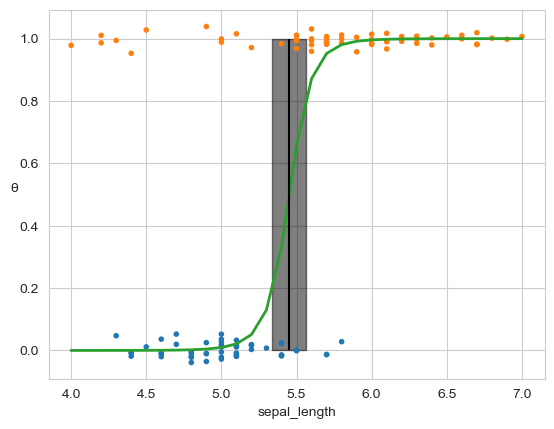

In [146]:
posterior_rlg = trace_rlg.posterior.stack(samples=("chain", "draw"))

theta = posterior_rlg['θ'].mean("samples")

idx = np.argsort(x_0)
plt.plot(x_0[idx], theta[idx], color='C2', lw=2)
plt.vlines(posterior_rlg['bd'].mean().item(), 0, 1, color='k')

bd_hpd = az.hdi(posterior_rlg['bd'].values)
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_0, np.random.normal(y_0, 0.02),
            marker='.', color=[f'C{x}' for x in y_0])
#az.plot_hdi(x_0, posterior_rlg['θ'].T, color='C2', smooth=False)

plt.xlabel('sepal_length');
plt.ylabel('θ', rotation=0)

In [87]:
x_0[idx]

array([4. , 4.2, 4.2, 4.3, 4.3, 4.4, 4.4, 4.4, 4.4, 4.5, 4.5, 4.6, 4.6,
       4.6, 4.6, 4.7, 4.7, 4.8, 4.8, 4.8, 4.8, 4.8, 4.9, 4.9, 4.9, 4.9,
       4.9, 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5.1, 5.1,
       5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.2, 5.2, 5.2, 5.2, 5.3, 5.4,
       5.4, 5.4, 5.4, 5.4, 5.4, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.5, 5.6,
       5.6, 5.6, 5.6, 5.6, 5.7, 5.7, 5.7, 5.7, 5.7, 5.7, 5.7, 5.8, 5.8,
       5.8, 5.8, 5.9, 5.9, 6. , 6. , 6. , 6. , 6.1, 6.1, 6.1, 6.1, 6.2,
       6.2, 6.3, 6.3, 6.3, 6.4, 6.4, 6.5, 6.6, 6.6, 6.7, 6.7, 6.7, 6.8,
       6.9, 7. ])

## Регрессия с использованием функции softmax

Одним из способов обобщения логистической регрессии для более чем двух классов является регрессия с применением функции softmax. Необходимо внести два изменения по сравнению с логистической регрессией: 

* во-первых, заменить логистическую функцию на функцию softmax:
$$ softmax_i(\mu) = \dfrac{\exp(\mu_i)}{\sum_i \exp( \mu_i)} $$
Другими словами, для получения выходных данных функции softmax для $i$-го элемента вектора $\mu$ берется экспонента от значения $\mu_i$ и делится на сумму экспонент всех значений, содержащихся в векторе $\mu$. Функция softmax гарантирует получение положительных значений, которые в сумме дают 1. Эта функция представляет собой сокращенную версию логистической функции при $k = 2$.

* во-вторых, заменить распределения Бернулли на категориальное распределение. Категориальное распределение – это обобщение распределения Бернулли для получения более двух выходных результатов. 

Рассмотрим уже известный нам набор ирисов:

In [154]:
iris = sns.load_dataset("iris")
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = StandardScaler().fit_transform(x_s)

In [174]:
with pm.Model() as model_s:
    α = pm.Normal('α', mu=0, sigma=10, shape=3)
    β = pm.Normal('β', mu=0, sigma=10, shape=(4,3))
    μ = pm.Deterministic('μ', α + pm.math.dot(x_s, β))
    θ = pm.math.softmax(μ, axis=1)
    yl = pm.Categorical('yl', p=θ, observed=y_s)
    trace_s = pm.sample(2000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 63 seconds.


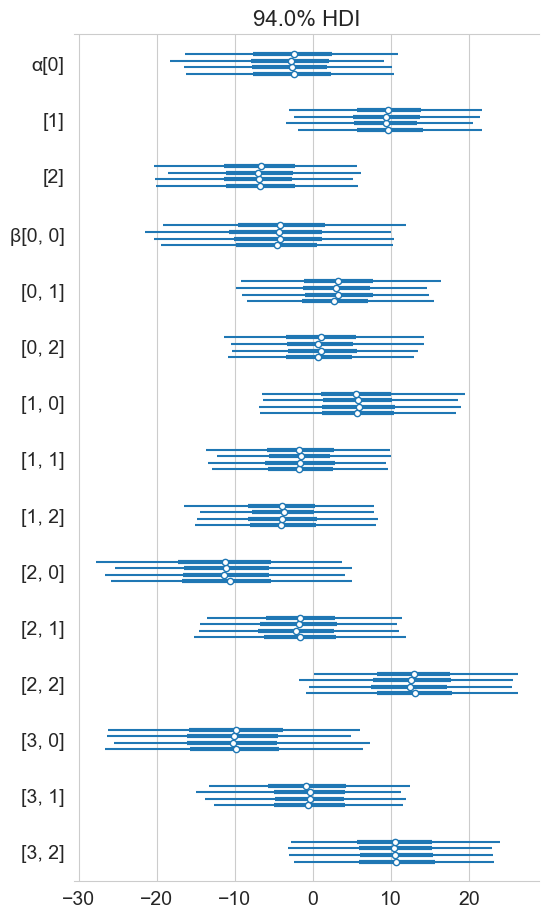

In [157]:
az.plot_forest(trace_s, var_names=['α', 'β']);

In [169]:
data_pred = trace_s.posterior['μ'].mean(("chain", "draw")).values

print(data_pred[:10])

y_pred = np.array([np.exp(point)/np.sum(np.exp(point), axis=0)
                                      for point in data_pred])
print(y_pred[45:55])

np.mean(y_s == np.argmax(y_pred, axis=1))

[[ 35.27128367   8.00378621 -42.82343292]
 [ 29.76624514   9.20743927 -38.54377457]
 [ 34.12576478   7.76648377 -41.31297509]
 [ 32.09000826   7.57826799 -39.077858  ]
 [ 37.13557581   7.23287674 -43.84544274]
 [ 34.34813264   7.1385764  -41.10733636]
 [ 35.34266487   6.43756262 -41.11408536]
 [ 33.8664625    7.91643388 -41.31349672]
 [ 31.17317201   7.70615363 -38.23352824]
 [ 31.78994442   8.7793035  -40.12107748]]
[[9.99999998e-01 1.66723292e-09 1.70875401e-29]
 [1.00000000e+00 2.44718877e-14 2.32370901e-36]
 [1.00000000e+00 2.40586539e-12 3.45165569e-33]
 [1.00000000e+00 5.06010317e-13 2.08463891e-35]
 [1.00000000e+00 1.75003315e-11 5.32122822e-33]
 [5.89033620e-13 9.99917871e-01 8.21290758e-05]
 [1.21928696e-10 9.99676101e-01 3.23899232e-04]
 [2.59563985e-14 9.96009198e-01 3.99080202e-03]
 [1.83288278e-11 9.99711883e-01 2.88116893e-04]
 [3.02031121e-14 9.95610290e-01 4.38971047e-03]]


0.98

### Дискриминативные и порождающие модели

Пока мы рассматривали логистическую регрессию и некоторые ее расширения. Во всех случаях мы пытались напрямую вычислить вероятность $p(y|x)$, то есть вероятность выбора определенного класса при известном $x$, где $x$ – признак (или несколько признаков), который измеряется (оценивается) для членов этих классов. 
Другими словами, выполнялась попытка прямого моделирования отображения независимых переменных в зависимые переменные с последующим использованием порогового значения для преобразования непрерывно вычисляемой вероятности в дискретную границу, которая позволяет распределять данные по классам.

Существует и другой вариант. Сначала моделируется $p(x|y)$, то есть распределение $x$ для каждого класса, затем данные распределяются по классам. Этот тип модели называется порождающим классификатором (generative classifier), так как модель создается на основе возможности генерировать (порождать) выборки данных из каждого класса. 

С другой стороны, логистическая регрессия представляет собой тип дискриминативного классификатора (discriminative classifier), поскольку такая модель пытается различить (discrimanate) классы, но при этом сохраняется возможность генерации выборок данных из каждого класса модели.

Давайте рассмотрим самый простой пример порождающей модели:

In [175]:
df = iris[iris['species'].isin(['setosa', 'versicolor'])]
y_0 = pd.Categorical(df['species']).codes
column = 'sepal_length'
x_0 = df[column].values

with pm.Model() as lda:
    μ = pm.Normal('μ', mu=0, sigma=20, shape=2)
    σ = pm.HalfNormal('σ', 10, shape=2)
    setosa = pm.Normal('setosa', mu=μ[0], sigma=σ[0], observed=x_0[:50]) 
    versicolor = pm.Normal('versicolor', mu=μ[1], sigma=σ[1], observed=x_0[50:]) 
    
    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    trace_lda = pm.sample(2000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.


Text(0.5, 0, 'sepal_length')

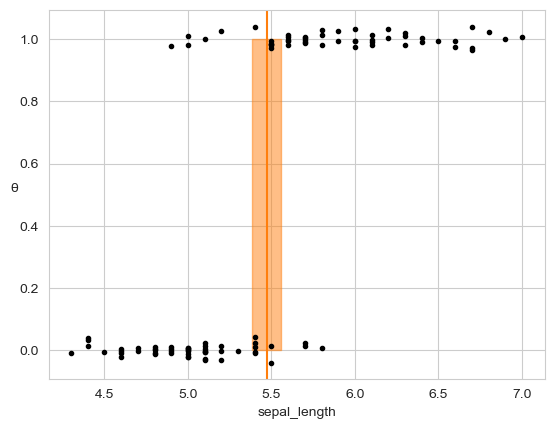

In [177]:
posterior_lda = trace_lda.posterior.stack(samples=("chain", "draw"))

plt.axvline(posterior_lda['bd'].mean(), ymax=1, color='C1')
bd_hpd = az.hdi(posterior_lda['bd'].values)

plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)

plt.plot(x_0, np.random.normal(y_0, 0.02), '.', color='k')
plt.ylabel('θ', rotation=0)
plt.xlabel('sepal_length')

In [178]:
az.summary(trace_lda)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],5.006,0.052,4.908,5.102,0.000,0.000,12898.0,6700.0,1.0
μ[1],5.937,0.076,5.789,6.076,0.001,0.001,10948.0,6236.0,1.0
σ[0],0.361,0.038,0.290,0.430,0.000,0.000,10188.0,6580.0,1.0
σ[1],0.530,0.055,0.429,0.632,0.001,0.000,10160.0,6665.0,1.0
bd,5.471,0.045,5.386,5.558,0.000,0.000,11955.0,6727.0,1.0


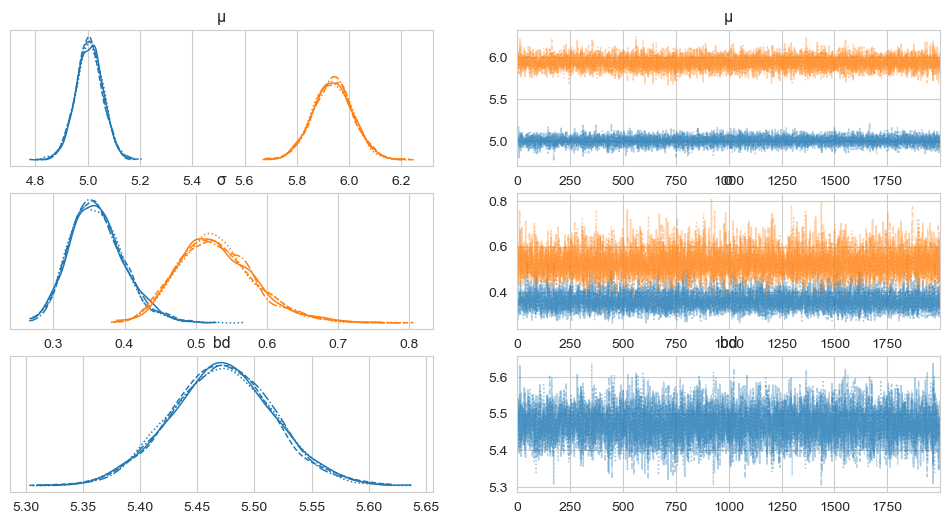

In [179]:
az.plot_trace(trace_lda,compact=True);